In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Add parent directory to Python path
sys.path.append('..')

from src.data import DataProcessor
from src.models import ModelWrapper  # Updated model with LSTM/GRU and Backpropagation
from src.utils import set_seeds, create_results_directory
from src.visualization import plot_predictions

# Set random seed for reproducibility
set_seeds(42)

# Create results directory if it doesn't exist
results_dir = create_results_directory()

2024-11-04 13:54:21.677742: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-04 13:54:21.684992: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-04 13:54:21.693112: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-04 13:54:21.695497: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-04 13:54:21.702346: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# Встановлення випадкових seed для відтворюваності
set_seeds(42)

# Step 1: Set File Paths and Target Column
file_path = '../data/raw/Train.csv'  # Replace with actual path
target_column = 'Power'          # Replace with actual target column

2024-11-04 13:54:24,753 - INFO - Random seeds set to 42


In [3]:
# Step 1: Set File Paths and Target Column
file_path = '../data/raw/Train.csv'
target_column = 'Power'

# Step 2: Initialize Data Processor and Prepare Data
data_processor = DataProcessor(file_path, target_column)
train_data, val_data, test_data = data_processor.prepare_data()


Data Ranges (scaled):
Training   - X: (98101, 15, 11), y: min=0.0000, max=1.0000
Validation - X: (28029, 15, 11), y: min=0.0000, max=0.9971
Test      - X: (14015, 15, 11), y: min=0.0000, max=0.9969

Temporal Split Check:
Training period: 2013-01-02 00:00:00 to 2015-10-20 21:00:00
Validation period: 2015-10-20 21:00:00 to 2016-08-07 20:00:00


I0000 00:00:1730728467.418051   58806 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730728467.432751   58806 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730728467.432788   58806 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730728467.434475   58806 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730728467.434497   58806 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

In [4]:
# Initialize model wrapper
model_wrapper = ModelWrapper(
    input_shape=(train_data.element_spec[0].shape[1], train_data.element_spec[0].shape[2])
)

# Display model architecture
model_wrapper.model.summary()

/home/dkat/courses/computational-intelligence/venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 15, 64)         │        19,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 15, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,905 (124.63 KB)

 Trainable params: 31,905 (124.63 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# Train model
history = model_wrapper.fit(train_data, val_data)

Epoch 1/50


2024-11-04 13:54:37.995864: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


3066/3066 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - loss: 0.1331 - mae: 0.1889 - val_loss: 0.0461 - val_mae: 0.1745 - learning_rate: 0.0010
Epoch 2/50
3066/3066 ━━━━━━━━━━━━━━━━━━━━ 22s 7ms/step - loss: 0.0438 - mae: 0.1652 - val_loss: 0.0426 - val_mae: 0.1639 - learning_rate: 0.0010
Epoch 3/50
3066/3066 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - loss: 0.0413 - mae: 0.1602 - val_loss: 0.0410 - val_mae: 0.1593 - learning_rate: 0.0010
Epoch 4/50
3066/3066 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - loss: 0.0404 - mae: 0.1585 - val_loss: 0.0402 - val_mae: 0.1559 - learning_rate: 0.0010
Epoch 5/50
3066/3066 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - loss: 0.0395 - mae: 0.1561 - val_loss: 0.0397 - val_mae: 0.1547 - learning_rate: 0.0010
Epoch 6/50
3066/3066 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - loss: 0.0385 - mae: 0.1537 - val_loss: 0.0390 - val_mae: 0.1535 - learning_rate: 0.0010
Epoch 7/50
3066/3066 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - loss: 0.0377 - mae: 0.1514 - val_loss: 0.0387 - val_mae: 0.1530 - learning_rate: 0.0

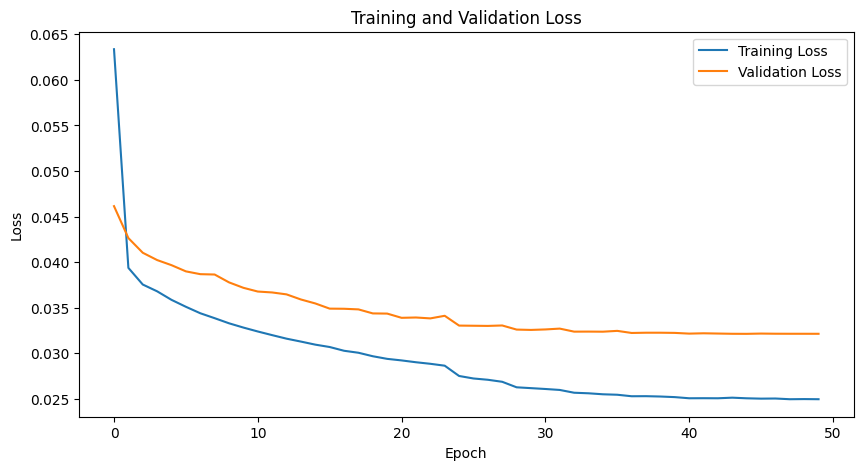

In [6]:
# 7. Візуалізація результатів тренування
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()